to Creat a Shapefile for the Volcano

In [13]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd

source:  
https://www.arcgis.com/home/item.html?id=c60377db3ff84128888c5a5fcbe42d4c  
  https://earthquake.usgs.gov/earthquakes/eventpage/us6000j6k5/executive

To Create a shapefile for the volcanoes.

In [20]:


shapefile_path = 'SDE_GLB_VOLC.shp'  # a point shapefile of volcanoes

gdf = gpd.read_file(shapefile_path)

java_gdf = gdf[gdf['LOCATION'] == 'Java'] #looking for volcanoes in Java

buffer_distance = 3000  # 3km buffer

java_gdf = java_gdf.to_crs(epsg=32748)#UTM Zone 48S for Java, using meter as unit

java_gdf['geometry'] = java_gdf['geometry'].buffer(buffer_distance)

java_gdf = java_gdf.to_crs(epsg=4326)

output_shapefile_path = 'java_volcano_buffers.shp'  # save as a polygon file

java_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')

print("Worked") #test


Worked


Data preprocessing

In [21]:
def clean_site_coords(file_path):
    data = pd.read_csv(file_path, skiprows=1)  # the first row is not what I want
    data.columns = ['site_id', 'Longitude', 'Latitude']
    data['site_id'] = data['site_id'].astype(int)
    data['Longitude'] = data['Longitude'].astype(float)
    data['Latitude'] = data['Latitude'].astype(float)
    return data

site_coords = clean_site_coords('gmf_l_data-csv/sitemesh_16.csv')

# read the data
def process_gmf_data(file_path):
    data = pd.read_csv(file_path, skiprows=1)  
    data.columns = ['site_id', 'event_id', 'gmv_PGA']
    data['site_id'] = data['site_id'].astype(int)
    return data

gmf_h_data = process_gmf_data('gmf_h_data-csv/gmf-data_15.csv')
gmf_l_data = process_gmf_data('gmf_l_data-csv/gmf-data_16.csv')

# merge site id and GMFs
gmf_h_data = gmf_h_data.merge(site_coords, on='site_id')
gmf_l_data = gmf_l_data.merge(site_coords, on='site_id')

# GeoDataFrame
gmf_h_gdf = gpd.GeoDataFrame(gmf_h_data, geometry=gpd.points_from_xy(gmf_h_data.Longitude, gmf_h_data.Latitude), crs="EPSG:4326")
gmf_l_gdf = gpd.GeoDataFrame(gmf_l_data, geometry=gpd.points_from_xy(gmf_l_data.Longitude, gmf_l_data.Latitude), crs="EPSG:4326")

print("Worked") #test

Worked


Based on whether the seismic wave path intersects with a volcanic buffer zone, the the appropriate GMF values are determined.

In [22]:
earthquake_source = Point(107.614, -7.233) #From USGS
volcano_buffers = gpd.read_file('java_volcano_buffers.shp')

sites_gdf = gmf_h_gdf[['geometry']].drop_duplicates()

combined_gmf = pd.DataFrame()

# Check if the path from each site to the earthquake source intersects with any volcanic buffer zones.
for idx, site in sites_gdf.iterrows():
    path = LineString([earthquake_source, site.geometry])
    intersects = volcano_buffers.intersects(path).any()

    if intersects:
        gmf_row = gmf_h_gdf[gmf_h_gdf['geometry'] == site.geometry]
    else:
        gmf_row = gmf_l_gdf[gmf_l_gdf['geometry'] == site.geometry]
    
    combined_gmf = pd.concat([combined_gmf, gmf_row], ignore_index=True)

combined_gmf.drop(columns='geometry', inplace=True) # There's no need to keep geometry column. But keeping it does no harm.

output_csv_path = 'combined_gmf.csv'
combined_gmf.to_csv(output_csv_path, index=False)# the new CSV file should be found in name 'combined_gmf.csv'

print("Worked")


Worked


Validation: Visualisation

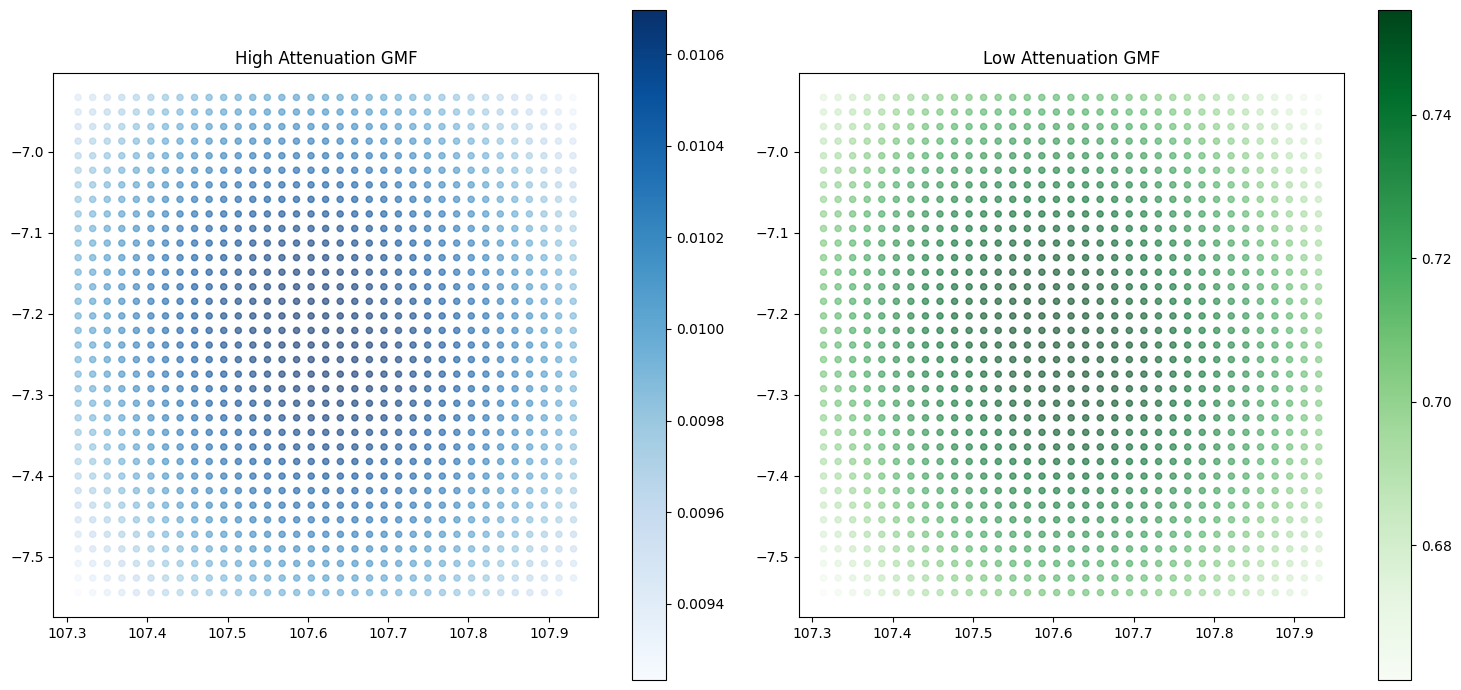

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

gmf_h_gdf.plot(ax=ax[0], column='gmv_PGA', legend=True, cmap='Blues', markersize=20, alpha=0.6)
ax[0].set_title('High Attenuation GMF')
legend_h = ax[0].get_legend()

gmf_l_gdf.plot(ax=ax[1], column='gmv_PGA', legend=True, cmap='Greens', markersize=20, alpha=0.6)
ax[1].set_title('Low Attenuation GMF')
legend_l = ax[1].get_legend()

plt.tight_layout()
plt.show()


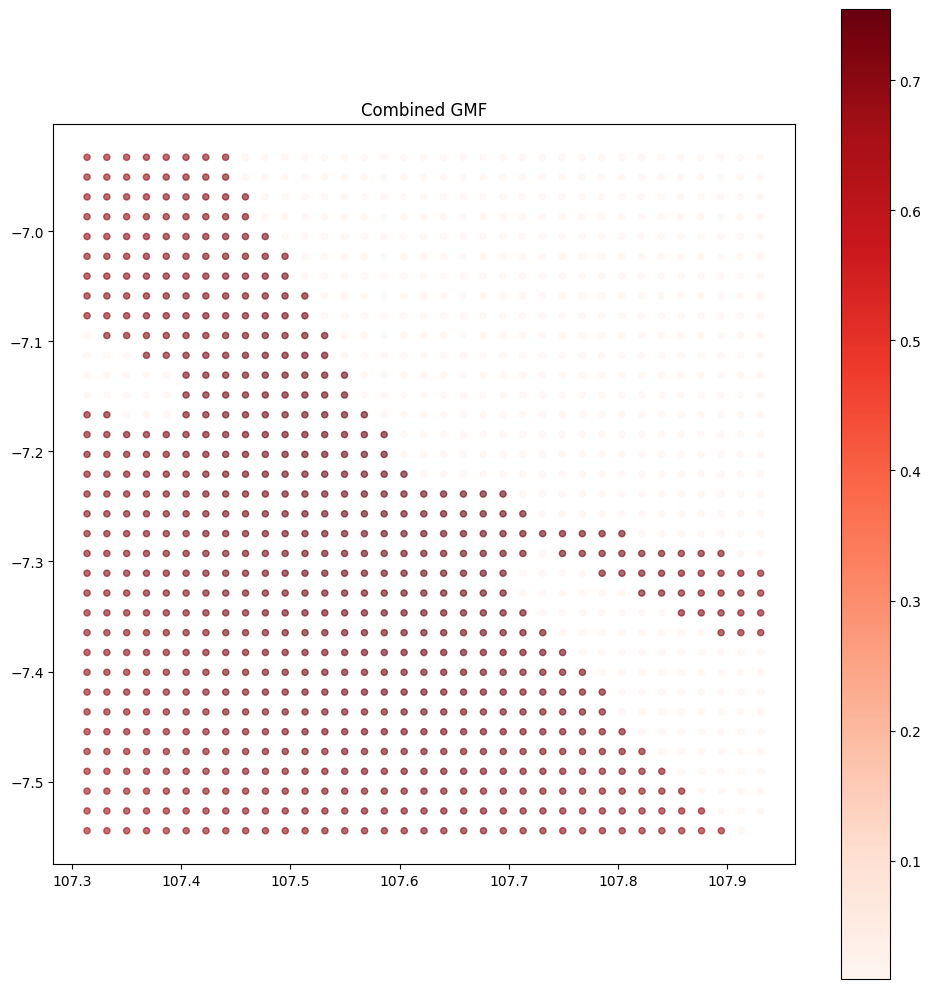

In [31]:
import matplotlib.pyplot as plt

combined_gmf_gdf = gpd.GeoDataFrame(combined_gmf, geometry=gpd.points_from_xy(combined_gmf.Longitude, combined_gmf.Latitude), crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

combined_gmf_gdf.plot(ax=ax, column='gmv_PGA', legend=True, cmap='Reds', markersize=20, alpha=0.6)

plt.title('Combined GMF')
plt.tight_layout()
plt.show()


References:  
  Kumagai, H. et al. (2020) Scattering and Attenuation Characteristics at Volcanoes Inferred From Envelope Widths of Natural and Active Seismic Sources. Journal of geophysical research. Solid earth. [Online] 125 (11), .
